In [1]:
import pandas as pd
import numpy as np
import pickle
from concurrent.futures import ProcessPoolExecutor
import time
import matplotlib.pyplot as plt
%matplotlib inline

# suppress warnings
from warnings import filterwarnings
filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

## Prepare the data

### Read the data

* test: Kaggle prediction set
* data: Data created in a public kernel (the xgboost kernel)

In [18]:
test = pd.read_csv('Data/test.csv').set_index('ID')
data = pd.read_pickle("data.pkl").drop("delta_revenue_lag_1", 1).astype(np.float16)

### Get dummies for categorical data

In [3]:
# CITY CODE DUMMIES
dummies = pd.get_dummies(data["city_code"].astype(int), prefix="cityCODE_")
data = data.join(dummies).drop(["city_code"], 1)

# TYPE CODE DUMMIES
dummies = pd.get_dummies(data["type_code"].astype(int), prefix="typeCODE_")
data = data.join(dummies).drop(["type_code"], 1)

# SUBTYPE CODE DUMMIES
dummies = pd.get_dummies(data["subtype_code"].astype(int), prefix="subtypeCODE_")
data = data.join(dummies).drop(["subtype_code"], 1)

# SUBTYPE CODE DUMMIES
dummies = pd.get_dummies(data["item_category_id"].astype(int), prefix="item_category_idCODE_")
data = data.join(dummies).drop(["item_category_id"], 1)

# Create new features to model cyclical nature of months
data["month_sin"] = np.sin(2*np.pi * data["date_block_num"]/12)
data["month_cos"] = np.cos(2*np.pi * data["date_block_num"]/12)
data["month_sin_cos"] = data["month_sin"] + data["month_cos"]

# Similar thought, different way
data["month_of_year"] = data["date_block_num"] % 12

### Get train set (0-33 months) and test set (month 34)

In [6]:
X_train = data[data.date_block_num <= 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num <= 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

# Reclaim memory
data = None

## Try out different models

### RF + Bagging (kaggle + OHE + sin/cos months)

#### 0.93510

In [8]:
rf = RandomForestRegressor(30, max_depth=9, n_jobs=2)
bagging = BaggingRegressor(rf, 30, max_samples=0.4, max_features=0.7, n_jobs=3)

bagging.fit(X_train, Y_train)

KeyboardInterrupt: 

In [ ]:
Y_pred = bagging.predict(X_test)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_pred
})

submission["item_cnt_month"] = submission["item_cnt_month"].clip(0,20)
submission.to_csv("simple_bagging_trigonometric.csv", index=False)

### Create a model for each shop: Do simple (linear) time series decomposition: find the monthly index and add to it the extrapolated trend calculated with linear regression

#### 1.28145

In [ ]:
def fit_model(params):

    i, shop_id, item_id = params
    
    # Report on progress
    if i % 10_000 == 0 and i>0:
        print((i)/len(test)*100, "% done")

    try:
        # select the subset of the dataset
        given_item = X_train[(X_train["item_id"]==item_id) & (X_train["shop_id"]==shop_id)].copy()

        ### Create rows for all missing months, and join the given item

        # Convert to int, just in case
        given_item["date_block_num"] = given_item["date_block_num"].astype(np.int8)

        # Create empty dataframes for joining (and debugging) purposes
        new_index = pd.Index(np.arange(12, 34, dtype=np.int8), name="date_block_num", dtype=np.int8)
        empty = pd.DataFrame(np.arange(12,34), index=new_index, columns=["date_block_num"])

        given_item = empty.merge(given_item.set_index("date_block_num"),
                 how='left', left_on="date_block_num", right_on="date_block_num",)

        # Fill empty with first observed value
        given_item.fillna(given_item.loc[~given_item.isnull().sum(1).astype(bool)].iloc[0], inplace=True)

        ### Calculate the trend

        trend = given_item.groupby("date_block_num").mean().rolling(12).mean().reset_index()

        # Fill empty with first observed value
        trend.fillna(trend.loc[~trend.isnull().sum(1).astype(bool)].iloc[0], inplace=True)

        merged = pd.merge(given_item, trend, how='left', on="date_block_num")

        # Data are now detrended
        for col in given_item.columns[1:-4]:
            given_item[col] = merged[[col+"_x"]].values - merged[[col+"_y"]].values

        # Fill empty with first non-nan row
        given_item.fillna(given_item.loc[~given_item.isnull().sum(1).astype(bool)].iloc[0], inplace=True)


        ### Calculate and remove seasonal indexes
        # (for all columns except: date_block_num, month_sin, month_cos, month_sin_cos, month_of_year)

        month_indexes = given_item.groupby("month_of_year").mean().reset_index()

        merged = pd.merge(given_item, month_indexes, how='left', on="month_of_year")

        # Data are now stationary
        for col in given_item.columns[1:-4]:
            given_item[col] = merged[[col+"_x"]].values - merged[[col+"_y"]].values

        # Reclaim memory
        merged = None

        ### Estimate the trend of month 34
        lr = LinearRegression()
        lr.fit(trend[11:21], trend[12:22])
        month34_trend = pd.DataFrame(lr.predict(trend[12:22])[-1:], columns=trend.columns)
        month34_trend

        ### Estimate the monthly index of month 34 (November, aka 10)
        month34_monthly_index = month_indexes[10:11].copy()

        ### Predict !
        predictions = pd.DataFrame(month34_trend.values + month34_monthly_index[month34_trend.columns].values, 
                                   columns=given_item.columns)["item_cnt_month"].values[0]
    except:
        # If ANY error occurs
        predictions = 0
        
    return predictions

In [ ]:
# Run the training over multiple processors

definition_start = time.time()

with ProcessPoolExecutor(max_workers=6) as p:
    returned = p.map(fit_model, [(i, shop_id,item_id) for i, (shop_id, item_id) in test.iterrows()])

definition_end = time.time()
    
ret = list(returned)

end = time.time()

print(f"Total time: {end - definition_start:.2f} seconds")
print(f"Pool executor time: {definition_end - definition_start:.2f} seconds")
print(f"List time: {end - definition_end:.2f} seconds")

In [ ]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": ret
})

submission["item_cnt_month"] = submission["item_cnt_month"].clip(0,20)
submission.to_csv("one_model_per_shop_item_simple_decomposition.csv", index=False)

### RF + Bagging (40 features from kaggle)

#### 0.92310

In [ ]:
rf = RandomForestRegressor(20, max_depth=8, n_jobs=2)
bagging = BaggingRegressor(rf, 20, max_samples=0.3, max_features=0.7, n_jobs=2)

bagging.fit(X_train, Y_train)

In [ ]:
Y_pred = bagging.predict(X_test)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_pred
})

submission["item_cnt_month"] = submission["item_cnt_month"].clip(0,20)
submission.to_csv("simple_bagging2.csv", index=False)

### LSTM without time dimension (i.e. 1 step)

In [11]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(1, len(X_train.columns))))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                76032     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 76,097
Trainable params: 76,097
Non-trainable params: 0
_________________________________________________________________


In [13]:
h = model_lstm.fit(X_train.values.reshape((-1, 1, len(X_train.columns))), 
                   Y_train.values.reshape((-1, 1)), batch_size=2048, epochs=20,
                  validation_split=0.15)

Train on 5461329 samples, validate on 963765 samples
Epoch 1/20
5461329/5461329 [==============================] - 35s 6us/step - loss: 1.2004 - mean_squared_error: 1.2004 - val_loss: 0.9542 - val_mean_squared_error: 0.9542
Epoch 2/20
5461329/5461329 [==============================] - 36s 7us/step - loss: 1.0383 - mean_squared_error: 1.0383 - val_loss: 0.9311 - val_mean_squared_error: 0.9311
Epoch 3/20
5461329/5461329 [==============================] - 36s 7us/step - loss: 0.9960 - mean_squared_error: 0.9960 - val_loss: 0.8048 - val_mean_squared_error: 0.8048
Epoch 4/20
5461329/5461329 [==============================] - 37s 7us/step - loss: 0.9540 - mean_squared_error: 0.9540 - val_loss: 0.8652 - val_mean_squared_error: 0.8652
Epoch 5/20
5461329/5461329 [==============================] - 36s 7us/step - loss: 0.9579 - mean_squared_error: 0.9579 - val_loss: 0.7883 - val_mean_squared_error: 0.7883
Epoch 6/20
5461329/5461329 [==============================] - 37s 7us/step - loss: 0.9512 - 

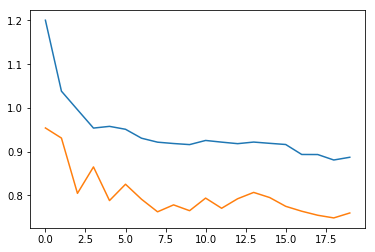

In [14]:
plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])

In [19]:
Y_pred = model_lstm.predict(X_test.values.reshape((-1, 1, len(X_train.columns))))

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_pred.reshape((-1,))
})

submission["item_cnt_month"] = submission["item_cnt_month"].clip(0,20)
submission.to_csv("simple_lstm31May.csv", index=False)

#### 0.92726 (0.98251 for 20 epochs)

In [38]:
Y_pred = model_lstm.predict(X_test.values.reshape((-1, 1, len(X_train.columns))))

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_pred.reshape((-1,))
})

submission["item_cnt_month"] = submission["item_cnt_month"].clip(0,20)
submission.to_csv("simple_lstm.csv", index=False)

### Try a different model 
#### 0.92726

In [27]:
model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape=(1, len(X_train.columns))))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(128))
model_lstm.add(Dense(256))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(128))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               184832    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
__________

In [29]:
h = model_lstm.fit(X_train.values.reshape((-1, 1, len(X_train.columns))), 
                   Y_train.values.reshape((-1, 1)), batch_size=2048, epochs=30,
                   validation_split=0.20)

Train on 5140075 samples, validate on 1285019 samples
Epoch 1/30
5140075/5140075 [==============================] - 39s 8us/step - loss: 1.1832 - mean_squared_error: 1.1832 - val_loss: 0.9255 - val_mean_squared_error: 0.9255
Epoch 2/30
5140075/5140075 [==============================] - 38s 7us/step - loss: 1.1836 - mean_squared_error: 1.1836 - val_loss: 0.8847 - val_mean_squared_error: 0.8847
Epoch 3/30
5140075/5140075 [==============================] - 39s 8us/step - loss: 1.1511 - mean_squared_error: 1.1511 - val_loss: 0.8463 - val_mean_squared_error: 0.8463
Epoch 4/30
5140075/5140075 [==============================] - 37s 7us/step - loss: 1.1904 - mean_squared_error: 1.1904 - val_loss: 0.8989 - val_mean_squared_error: 0.8989
Epoch 5/30
5140075/5140075 [==============================] - 37s 7us/step - loss: 1.1039 - mean_squared_error: 1.1039 - val_loss: 0.8624 - val_mean_squared_error: 0.8624
Epoch 6/30
5140075/5140075 [==============================] - 38s 7us/step - loss: 1.1059 -

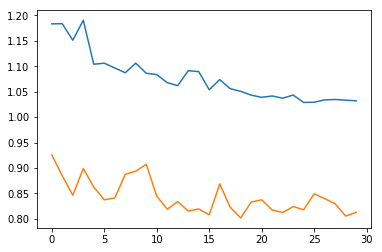

In [30]:
plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])

In [31]:
Y_pred = model_lstm.predict(X_test.values.reshape((-1, 1, len(X_train.columns))))

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_pred.reshape((-1,))
})

submission["item_cnt_month"] = submission["item_cnt_month"].clip(0,20)
submission.to_csv("dense_lstm31Mayv2.csv", index=False)

### Voting Regressor: simple average the 3 previous models

#### 1.03699

In [198]:
df1 = pd.read_csv("simple_bagging.csv")
df2 = pd.read_csv("simple_bagging2.csv")
df3 = pd.read_csv("simple_lstm.csv")

df1["item_cnt_month"] = (df1["item_cnt_month"] + df2["item_cnt_month"] + df3["item_cnt_month"])/3
df1.to_csv("simple_voting.csv", index=False)